In [1]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(3,), name="first_input")
features = layers.Dense(64, activation="relu")(inputs)
outputs = layers.Dense(10, activation="softmax")(features)
model= keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_input (InputLayer)    [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


## multiple inputs, multiple outputs. functional API

In [2]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

#defining model inputs
""" This section just defines the kind of input data the model will be processing"""
title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

#combine input features into a single tensor, features by concatenating them.
features = layers.Concatenate()([title, text_body, tags])

#apply an intemediate layer to recombine input features into richer representaions
features = layers.Dense(64, activation="relu")(features)

#define model outputs
priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
departments = layers.Dense(num_departments, activation="softmax", name="department")(features)

#create a model by specifying its inputs and outputs
model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, departments])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title (InputLayer)             [(None, 10000)]      0           []                               
                                                                                                  
 text_body (InputLayer)         [(None, 10000)]      0           []                               
                                                                                                  
 tags (InputLayer)              [(None, 100)]        0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 20100)        0           ['title[0][0]',                  
                                                                  'text_body[0][0]',        

In [3]:
import numpy as np

num_samples = 1280

#dummy input data
"""These are the real inputs data"""
title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size)) 
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags)) 

#dummy target data
priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

model.compile(optimizer="rmsprop",
             loss=["mean_squared_error", "categorical_crossentropy"],
             metrics=[["mean_absolute_error"], ['accuracy']])
model.fit([title_data, text_body_data, tags_data], [priority_data, department_data], epochs=1)
model.evaluate([title_data, text_body_data, tags_data], [priority_data, department_data])
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

40/40 [==============================] - 0s 3ms/step


## alternative 2

In [5]:
model.compile(optimizer="rmsprop",
             loss={"priority":"mean_squared_error", "department":"categorical_crossentropy"},
             metrics={"priority":["mean_absolute_error"], "department":['accuracy']})
model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data},
         {"priority": priority_data, "department": department_data}, epochs=1)
model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data},
          {"priority": priority_data, "department": department_data})
priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})

40/40 [==============================] - 0s 3ms/step


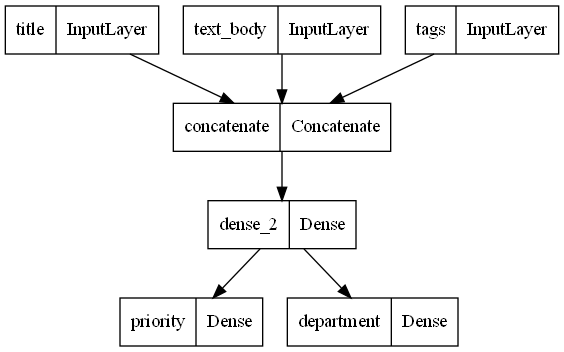

In [4]:
import pydot
import graphviz

keras.utils.plot_model(model, "ticket_classifier.png")

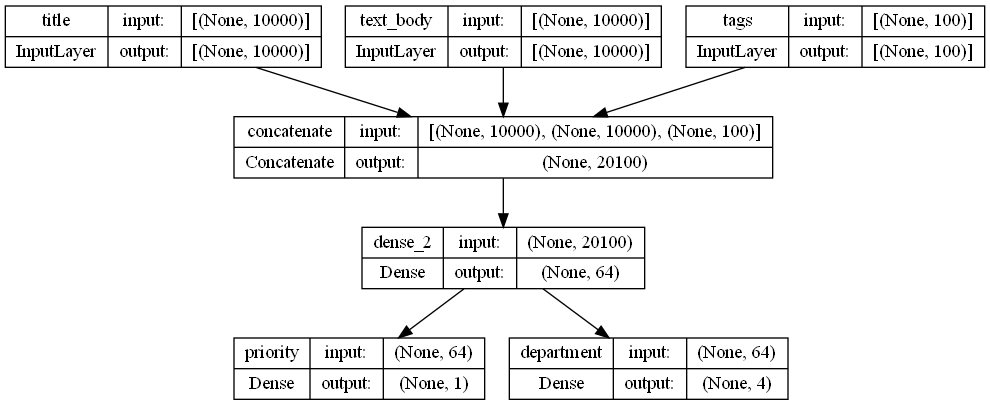

In [4]:
keras.utils.plot_model(model, "ticket_with_shape_info.png", show_shapes=True)

In [5]:
model.layers

In [6]:
model.layers[3].input


[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

In [7]:
model.layers[3].output

<KerasTensor: shape=(None, 20100) dtype=float32 (created by layer 'concatenate')>

In [10]:
model.layers[4].output

<KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'dense_2')>

## creating a new model by reusing intermediate layers output

In [13]:
features = model.layers[4].output
difficulty = layers.Dense(3, activation="softmax", name='difficulty')(features)

new_model = keras.Model(
inputs=[title, text_body, tags],
outputs=[priority, departments, difficulty])

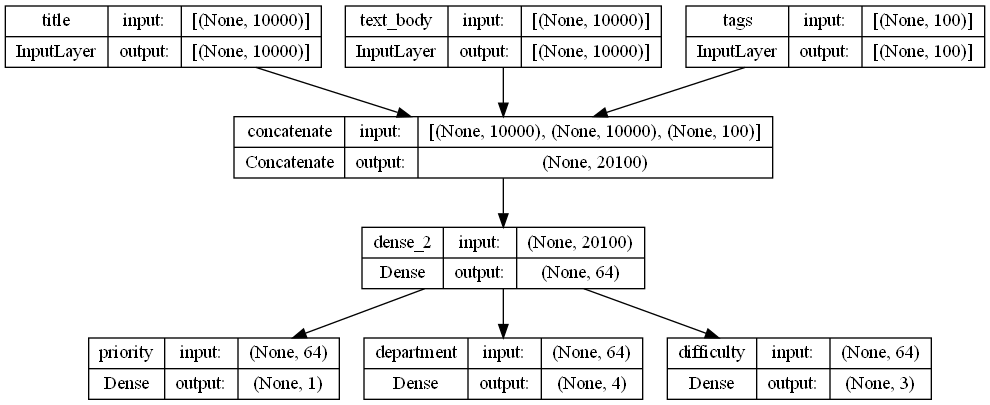

In [14]:
keras.utils.plot_model(new_model, "updated_ticket_classifier.png", show_shapes=True)